In [16]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [50]:
from glomerulus import Glomerulus, Patch, KidneySampleDataset, get_glomeruli, generate_glomerulus_patches
from networks import CBAM_R2UNet_v2_Large
from utils import read_tiff, dataset_label_mean
from losses import dice_loss

In [18]:
TEST_IMAGE_PATH = './kidney_dataset/train/aaa6a05cc.tiff'
TEST_LABEL_PATH = './kidney_dataset/train/aaa6a05cc.json'

test_image = read_tiff(TEST_IMAGE_PATH)


In [4]:
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
test_patches = generate_glomerulus_patches(
    patch_size = 512,
    num_patches = 100,
    glomeruli = test_glomeruli,
    image = test_image
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
dataset = KidneySampleDataset(test_patches)

Rendering Patches:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
del test_glomeruli
del test_patches

NameError: name 'test_glomeruli' is not defined

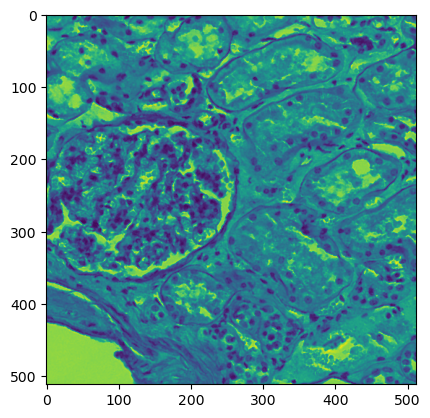

In [27]:
plt.imshow(dataset.image_array[0, :, :, 0])

In [52]:
model = CBAM_R2UNet_v2_Large((256, 256), (512, 512)).cuda()
model.load_state_dict(torch.load('./dataset_ratio_models/CBAM_R2UNet_v2_Large_256_train_0.6_0.4.npy_Weighted_BCE_Dice_lr0.001_t1000_b16_best_loss.npz'))

<All keys matched successfully>

In [53]:
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img = np.zeros((
    int(np.ceil(test_image.shape[1] / 512) * 512),
    int(np.ceil(test_image.shape[2] / 512) * 512)
))
mask_img = np.zeros((
    int(np.ceil(test_image.shape[1] / 512) * 512),
    int(np.ceil(test_image.shape[2] / 512) * 512)
))
for idx_y in tqdm(range(0, test_image.shape[1], 512)):
    for idx_x in range(0, test_image.shape[2], 512):
        center_x = idx_x + 512 // 2
        center_y = idx_y + 512 // 2
        test_patch = Patch(
            center_x = center_x,
            center_y = center_y,
            theta = 0,
            patch_size = 512,
            glomeruli = test_glomeruli,
            image = test_image
        ).render_image()
        out = model.forward(torch.unsqueeze(torch.tensor(test_patch), 0).type(torch.cuda.FloatTensor))
        out_img[idx_y: idx_y+512, idx_x: idx_x+512] = out.cpu().detach().numpy()[0][0]
        mask_img[idx_y: idx_y+512, idx_x: idx_x+512] = Patch(
            center_x = center_x,
            center_y = center_y,
            theta = 0,
            patch_size = 512,
            glomeruli = test_glomeruli,
            image = test_image
        ).render_mask()

  0%|          | 0/37 [00:00<?, ?it/s]

In [54]:
out = model.forward(torch.unsqueeze(torch.tensor(test_patch), 0).type(torch.cuda.FloatTensor))

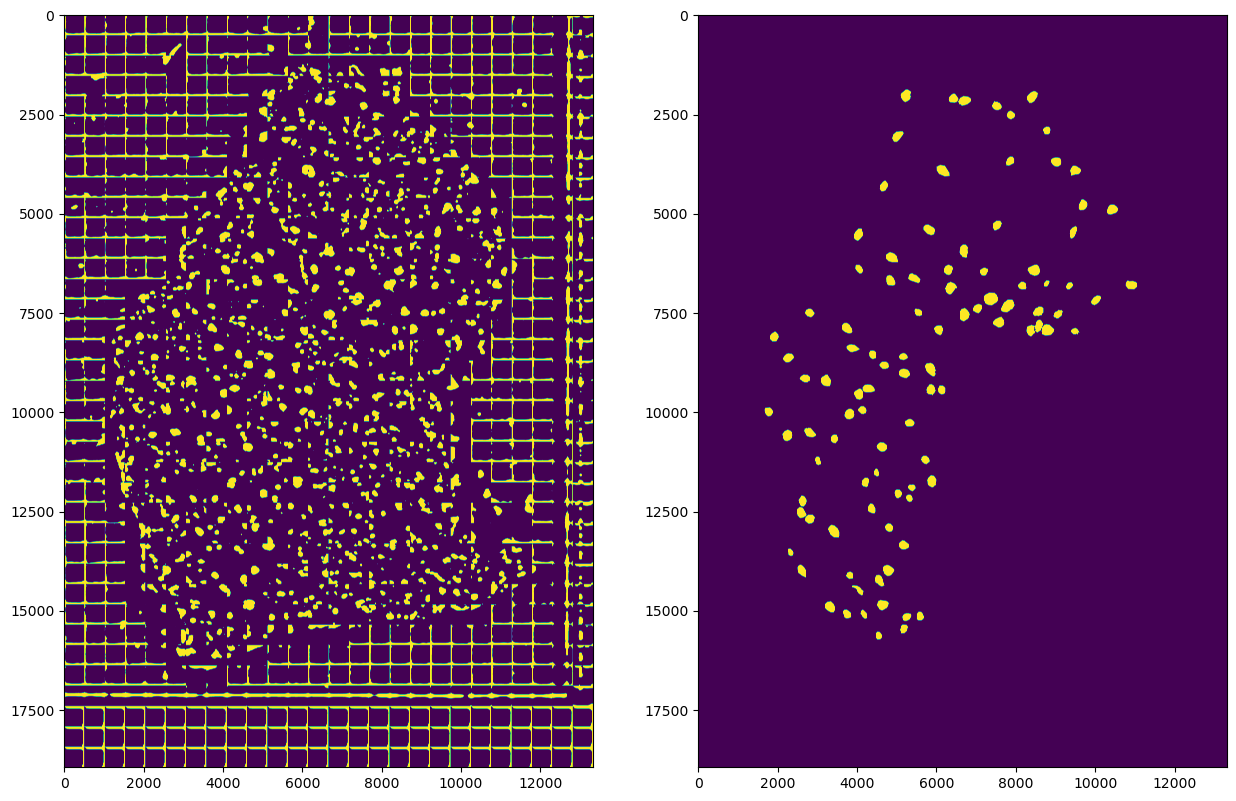

In [56]:

out = out_img > 0.5
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(out)
axes[1].imshow(mask_img)

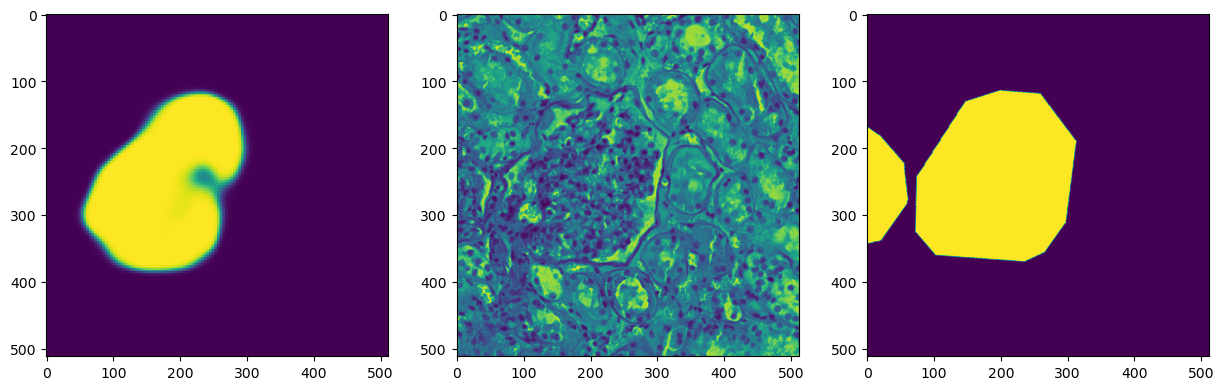

In [46]:
idx = 50
image = dataset.image_array[idx, :, :, 0]
mask = dataset.image_array[idx, :, :, 1]
out = model.forward(torch.unsqueeze(torch.unsqueeze(torch.tensor(image), 0), 0).type(torch.cuda.FloatTensor)).cpu().detach().numpy()[0][0]
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
axes[0].imshow(out)
axes[1].imshow(image)
axes[2].imshow(mask)

In [48]:
test_image.shape[1]

18484

In [59]:
out_img[0: 0+512, 0: 0+512].shape

(512, 512)

In [110]:
import random
def generate_random_patches(patch_size, num_patches, glomeruli, image):
    patches = []
    for _ in tqdm(range(num_patches)):
        glomeruli_num = len(glomeruli)
        glomerulus = glomeruli[random.randrange(0, glomeruli_num)]
        
        center_x = random.randrange(
            patch_size // 2,
            image.shape[2] - patch_size // 2
        )
        
        center_y = random.randrange(
            patch_size // 2,
            image.shape[1] - patch_size // 2
        )
        
        theta = random.random()*360
        
        patches.append(Patch(
            center_x = center_x,
            center_y = center_y,
            theta = theta,
            patch_size = patch_size,
            glomeruli = glomeruli,
            image = image
        ))
    return patches

  0%|          | 0/100 [00:00<?, ?it/s]

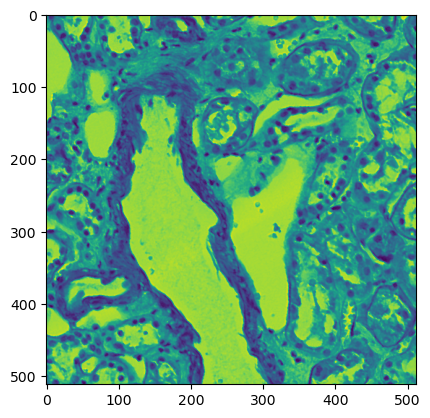

In [111]:
test_patches = generate_random_patches(
    patch_size = 512,
    num_patches = 100,
    glomeruli = test_glomeruli,
    image = test_image
)

for patch in test_patches:
    patch.render_image()
plt.imshow(test_patches[4].render_image()[0])

In [104]:
test_patches[2].center_x
# test_patches[2].center_y

4683

In [85]:
Patch(
    center_x = 14759,
    center_y = 8436,
    theta = 0,
    patch_size = 512,
    glomeruli = test_glomeruli,
    image = test_image
).render_image()

ValueError: could not broadcast input array from shape (1,1452,0) into shape (1,1452,431)

In [107]:
test_patches[4].center_x

15476